# Hypothesis Testing

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import matplotlib.pylab as plt
%matplotlib inline

from scipy import special

from scipy import stats

## Ex 1:  Swain vs. Alabama ##

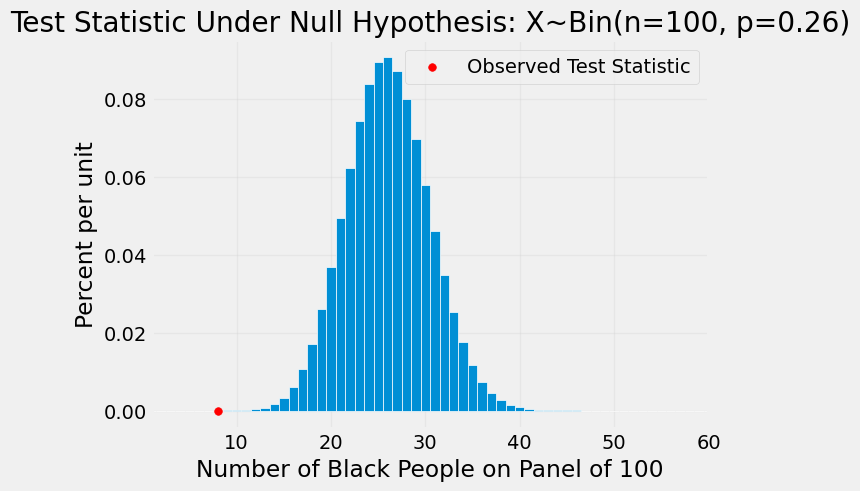

In [36]:
k = np.arange(101)
p = special.comb(100, k)*(0.26**k)*(0.74**(100-k))
#p = stats.binom.pmf(k, 100, .26),

fig, ax = plt.subplots()

ax.bar(k, p, width=1, ec='white');
ax.set_axisbelow(True)
ax.grid(alpha=0.25)
plt.xlim(1,60)
plt.title("Test Statistic Under Null Hypothesis: X~Bin(n=100, p=0.26)");
plt.xlabel("Number of Black People on Panel of 100")
plt.ylabel("Percent per unit")
plt.scatter(8, -.0001, color="red", s=30, label="Observed Test Statistic")
plt.legend()

plt.show()

In [6]:
#Hypothesis Test:  
# Null:  p=0.26
# Alternative  p<0.26


# (1) Calculate the p-value: probability of region beyond observed value
print("P(X<=8) = ",p[0:9].sum())

# Or can do this directly using CDF:
from scipy import stats
stats.binom.cdf(8, 100, .26)
               


# (2) See if this is less than your pre-chosen significance level

P(X<=8) =  4.734794997889318e-06


4.73479499788932e-06

**Conclusion:**

In [8]:
#Conclusion:  since p<0.01, we reject the null hypothesis at the 1% significance level

## Ex 2: Alameda County Jury Panels ##

In [10]:
eth =['Asian', 'Black', 'Latino', 'White', 'Other']

jury = pd.DataFrame(
    {       
        'Eligible': [0.15, 0.18, 0.12, 0.54, 0.01],
         'Panels': [0.26, 0.08, 0.08, 0.54, 0.04]
        
    }, index = eth
)

jury

,Eligible,Panels
Asian,0.15,0.26
Black,0.18,0.08
Latino,0.12,0.08
White,0.54,0.54
Other,0.01,0.04


In [12]:
jury.plot.barh();

In [14]:
#Make an array with the eligible proportions assumed under the null hypothesis

null_hyp=np.array([0.15, 0.18, 0.12, 0.54, 0.01])

In [16]:
# Simulate a draw of size N assuming the null hypothesis:


N=1423  #from the ACLU report
simulated = stats.multinomial.rvs(N, null_hyp)

simulated_proportions = simulated/N

print(simulated)
print(simulated_proportions)

[198 238 184 787  16]
[0.13914266 0.16725228 0.12930429 0.55305692 0.01124385]


In [18]:
# The actual observed distribution (Panels) looks quite different
# from the simulation -- try running this several times to confirm!
jury_with_simulated=jury.copy()
jury_with_simulated["Simulated"]=simulated_proportions

print(jury_with_simulated)

jury_with_simulated.plot.barh()

        Eligible  Panels  Simulated
Asian       0.15    0.26   0.139143
Black       0.18    0.08   0.167252
Latino      0.12    0.08   0.129304
White       0.54    0.54   0.553057
Other       0.01    0.04   0.011244


<Axes: >

## Distance Between Distributions

In [20]:

# In this case, we need to understand how each of the 5 categories
# differ from their expected values according to the model

jury_with_difference=jury.copy()
jury_with_difference["Difference"]=jury["Panels"]-jury["Eligible"]
jury_with_difference

,Eligible,Panels,Difference
Asian,0.15,0.26,0.11
Black,0.18,0.08,-0.10
Latino,0.12,0.08,-0.04
White,0.54,0.54,0.00
Other,0.01,0.04,0.03


## Total Variation Distance

In [22]:
# This was the statistic we chose
def tvd(dist1, dist2):
    return sum(abs(dist1 - dist2))/2

In [24]:
# The TVD of our observed data (Panels) from their expected values
# assuming the model is true 
obsvd_tvd = tvd(jury['Panels'],null_hyp)
obsvd_tvd

0.14

In [26]:
# The TVD of a model simluation from its expected values
tvd(stats.multinomial.rvs(N, null_hyp)/N, null_hyp)

0.01453267744202387

In [28]:
def simulated_tvd():
    return tvd(stats.multinomial.rvs(N, null_hyp)/N, null_hyp)


num_simulations = 1000000

tvds = np.array([simulated_tvd() for i in range(num_simulations)])


plt.hist(tvds, density=True);  
plt.xlabel("Total Distance Variation")
plt.ylabel("Percent per unit")
    

Text(-19.21666666666667, 0.5, 'Percent per unit')

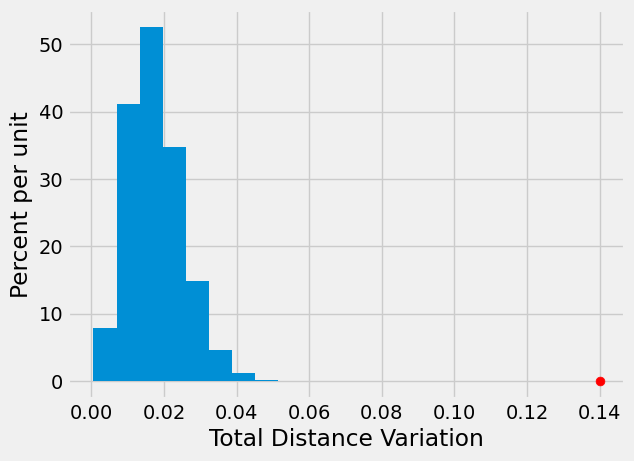

In [38]:
# Add the observed test statistic to the plot:
plt.hist(tvds, density=True);  
plt.xlabel("Total Distance Variation")
plt.ylabel("Percent per unit")

    
plt.scatter(obsvd_tvd, -.001, color="red", s=40)

plt.show()



In [30]:

# (1) Calculate the empirical p-value: simulation area beyond observed value

sum(tvds>=obsvd_tvd)/1000000

# (2) See if this is less than 1% (or our initially chosen significance level)

0.0

**Conclusion**:
Our empiricial p-value is $0$ (note that the actual theoretical p-value isn't 0, but since our simulations showed 0 observations out of $1000000$ that had a TVD greater than or equal to 0.14, we know that the theoretical p-value is at least less than $1/1000000$.

Given that our empirical p-value is less than our significance cutoff of $0.01$ we **REJECT THE NULL** hypothesis.      It is important for us to be precise about what we can conclude from our analysis:

**We can conclude that the distribution provided for the panelists who reported for service does not look like a random sample from the estimated distribution in the eligible population.**

Our analysis supports the ACLU’s conclusion that the panels were not representative of the distribution provided for the eligible jurors.

As with most such analyses, ours doesn’t say why the distributions are different.   See here for a more detailed discussion about this case:  https://inferentialthinking.com/chapters/11/2/Multiple_Categories.html

## Ex 3: Mendel and Pea Flowers ##

Mendel's null: 75% chance of purple flowers

Observed data:  grew 929 plants, of which 709 had purple flowers


In [50]:
#Simulate one value of the test statistic under the null hypothesis:  75% chance of purple flowers out of sample of 929

predicted_proportions = np.array([.75, .25])

def test_statistic_purple_flowers(n=929):
    num_purple=stats.binom.rvs(n, 0.75)
    #print("Number of purple flowers out of 929:",num_purple)
    return abs(num_purple/n*100-75)

test_statistic_purple_flowers()

0.18837459634013953

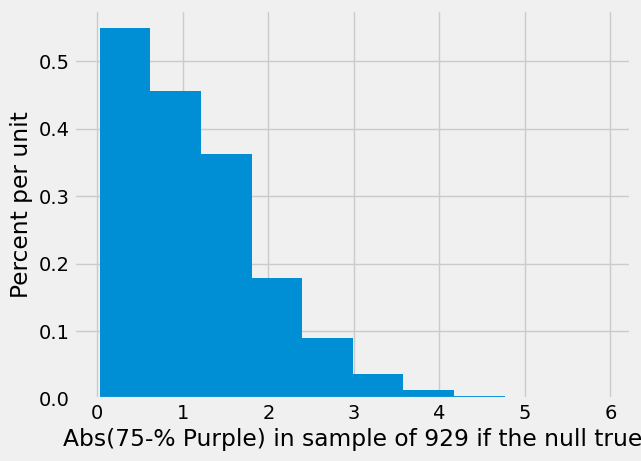

In [58]:
# Simulate 10,000 copies of the test statistic
num_simulations = 10000;

outcomes=[]

for i in np.arange(num_simulations):
    outcomes = np.append(outcomes, test_statistic_purple_flowers(929))

plt.hist(outcomes, density=True);

#ax.set_axisbelow(True)
#ax.grid(alpha=0.25)
plt.xlabel("Abs(75-% Purple) in sample of 929 if the null true")
plt.ylabel("Percent per unit")
plt.show()


## Our Decision

In [60]:
#Compare to observed test statistic:
## Mendel had 929 plants, of which 709 had purple flowers

observed_purples = 709 / 929*100

observed_test_statistic=abs(observed_purples-75)
observed_test_statistic


1.318622174381062

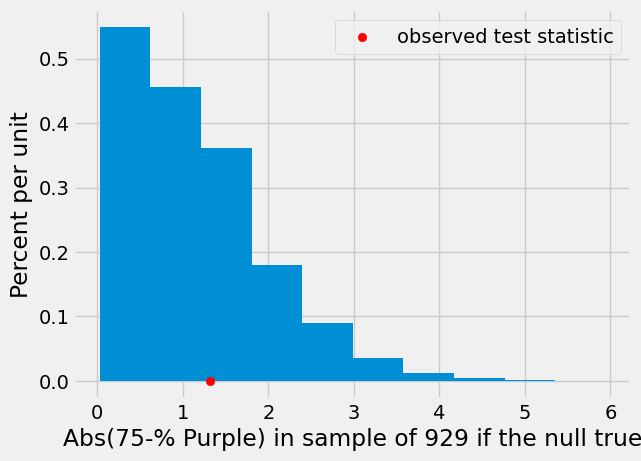

In [64]:
#Plot

plt.hist(outcomes, density=True);
#ax.set_axisbelow(True)
#ax.grid(alpha=0.25)
plt.xlabel("Abs(75-% Purple) in sample of 929 if the null true")
plt.ylabel("Percent per unit")

plt.scatter(observed_test_statistic, -.0001, color="red", label = 'observed test statistic')
plt.legend()

plt.show()

In [66]:
# (1) Calculate the EMPIRICAL p-value: simulation area beyond observed value

sum(outcomes>=observed_test_statistic)/ num_simulations

# (2) See if this is less than 5% (or our initially chosen significance level)


0.3658

## Conclusion:  
Since 0.3655> 0.05, we **FAIL TO REJECT** the null hypothesis that the proportion of purple flowers is 0.75.  The evidence is consistent with our null hypothesis.  This does NOT prove that our null is true.  It just proves that we don't have evidence to reject it, so we will continue using the null hypothesis.


## Ex 4: The TA's Defense ##

In [ ]:
scores = pd.read_csv('scores_by_section.csv')
scores

In [ ]:
scores.groupby("Section").count()

In [ ]:
scores.groupby("Section").mean()

In [ ]:
observed_average = 13.6667 

In [ ]:
scores["Midterm"].mean()

In [ ]:
random_sample=scores.sample(27,replace=False)
random_sample["Midterm"].mean()

In [ ]:
random_sample['Midterm'].mean()

In [ ]:
# Simulate one value of the test statistic 
# under the hypothesis that the section is like a random sample from the class

def random_sample_midterm_avg():
    random_sample = scores.sample(27, replace=False)
    return random_sample['Midterm'].mean()

In [ ]:
# Simulate 100,000 copies of the test statistic


num_sim=100000

sample_averages = np.array([random_sample_midterm_avg() for i in range(num_sim)])




In [ ]:
# Compare the simulated distribution of the statistic
# and the actual observed statistic

plt.hist(sample_averages, density=True);

plots.scatter(observed_average, -0.01, color='red', s=120);

## Calculating p-value

In [ ]:
# (1) Calculate the p-value: simulation area beyond observed value
np.count_nonzero(sample_averages <= observed_average) / num_sim
# (2) See if this is less than 5%

## Conclusion:  
Since 0.05746> 0.05, we **FAIL TO REJECT** the null hypothesis that any difference in scores for section 3 was just due to random chance

In [ ]:
from scipy import stats


## Theoretical Calculation:

We could have done this without using simulations thanks to the Central Limit Theorem!   

By the CLT, $$\bar{X}_{27} \sim N(\mu, \sigma^2/27)$$ where $\mu = $ pop mean = `scores["Midterm"].mean()`   and                    

$\sigma = $ pop_std = `pop_std=scores["Midterm"].std(ddof=0)`


Thus 

p-value =   $P(\bar{X}_{27}<=13.667)$ = `stats.norm.cdf(13.667,pop_mean, pop_std/np.sqrt(27))`


In [ ]:
pop_mean=scores["Midterm"].mean()

In [ ]:
pop_std=scores["Midterm"].std(ddof=0)

In [ ]:
stats.norm.cdf(13.667,pop_mean, pop_std/np.sqrt(27))

Again, since $p= 0.059> 0.05$, we **FAIL TO REJECT** the null hypothesis that any difference in scores for section 3 was just due to random chance